# Exploring Credit Reporting Errors: A Text Mining Analysis of Consumer Complaint Data

## Final Project for Course PPOL 566: Data Science III - Advanced Modeling Techniques, Fall 2020

#### Andy Green
#### Georgetown University
#### December 16, 2020

This file is the second of two Jupyter Notebooks used in this analysis.

- Purpose: this file contains the code for all of the analysis steps described throughout the report.
- Inputs: 'complaints_sample.csv'
- Outputs: this file produces a wide array of .csv and .png outputs containing the tables and graphics used in the report. These files can all be found in the “Tables_Graphics” sub-folder in the repository.
    - Note: the code chunks that produce these outputs are currently commented out to avoid creating unexpected files on the user’s machine.

### Section 1: Initial Data Set-up Tasks

In [1]:
## Importing necessary packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import copy

In [2]:
## Read in the sample of complaints data
complaints_data = pd.read_csv('Data/complaints_sample.csv')

## Check it out
complaints_data.head(5)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,2020-05-31,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,916XX,None,Consent provided,Web,05/31/20,Closed with explanation,Yes,NaN,3676629
1,2020-06-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,"There is inaccurate, misleading, incorrect, ou...",None,"EQUIFAX, INC.",TX,761XX,None,Consent provided,Web,06/05/20,Closed with explanation,Yes,NaN,3685359
2,2020-06-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,To : Whom It May concern : I am writing to dis...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,None,None,Consent provided,Web,06/02/20,Closed with explanation,Yes,NaN,3680584
3,2019-12-12,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I recently reviewed my credit profile and noti...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,932XX,None,Consent provided,Web,12/12/19,Closed with non-monetary relief,Yes,NaN,3466718
4,2020-02-11,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,I sent TransUnion a letter requesting my infor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MD,21030,None,Consent provided,Web,02/11/20,Closed with explanation,Yes,NaN,3528713


In [3]:
## Grabbing just the narrative text data in a separate object
complaints = complaints_data['consumer_complaint_narrative']

## Check it out
complaints.head(10)

0    ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...
1    There is inaccurate, misleading, incorrect, ou...
2    To : Whom It May concern : I am writing to dis...
3    I recently reviewed my credit profile and noti...
4    I sent TransUnion a letter requesting my infor...
5    I attended XXXX  XXXX XXXX  and received fundi...
6    XXXX continues to report bankruptcy related in...
7    I am a victim od identity theft. My informatio...
8    TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S...
9       These accounts arent mine. Please remove them.
Name: consumer_complaint_narrative, dtype: object

### Section 2: Preprocessing and Data Exploration / Summaries

In [4]:
## Adding a few problematic words to the default stop words list before pre-processing
stop_words_adjusted = text.ENGLISH_STOP_WORDS.union(['xx','xxxx','xxxxxxxx','00'])

In [5]:
#### Determining the optimal min doc frequency to use as part of preprocessing

## Creating empty object to store results
min_doc_frequencies = []

## Looping through values of min doc frequency of 1-20 and appending the resulting number of features for each
for i in range(1,21):
    
    ## Implementing the tf-idf vectorizer with min_df of i
    tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words_adjusted, min_df = i)
    
    ## Creating the dtm
    dtm = tfidf_vectorizer.fit_transform(complaints)
    
    ## Finding and appending the number of features for that min_df
    min_doc_frequencies.append([i,len(tfidf_vectorizer.get_feature_names())])
    
## Check it out
min_doc_frequencies

[[1, 8304],
 [2, 4995],
 [3, 3952],
 [4, 3394],
 [5, 3077],
 [6, 2789],
 [7, 2588],
 [8, 2418],
 [9, 2299],
 [10, 2205],
 [11, 2101],
 [12, 2011],
 [13, 1945],
 [14, 1875],
 [15, 1815],
 [16, 1757],
 [17, 1711],
 [18, 1651],
 [19, 1603],
 [20, 1557]]

In [6]:
## Storing results in dataframe
min_freqs_df = pd.DataFrame(min_doc_frequencies,columns=['Minimum_Document_Frequency','Number_of_Features'])
min_freqs_df.head()

,Minimum_Document_Frequency,Number_of_Features
0,1,8304
1,2,4995
2,3,3952
3,4,3394
4,5,3077


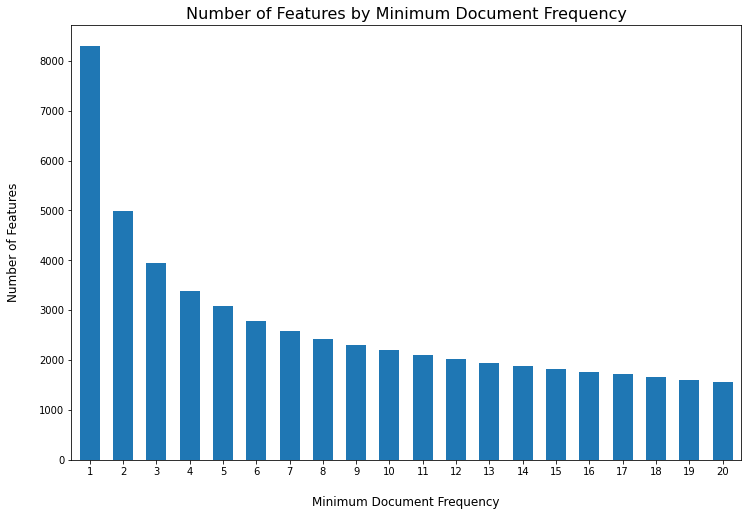

In [7]:
## Plotting the min document frequency counts
min_freqs_df.plot(x = 'Minimum_Document_Frequency', 
                  y = 'Number_of_Features', 
                  kind = 'bar',
                  figsize=(12,8),
                  legend = False,
                  width = 0.6)

plt.xlabel('\nMinimum Document Frequency',fontsize=12)
plt.ylabel('Number of Features\n',fontsize=12)
plt.title('Number of Features by Minimum Document Frequency',fontsize=16)
plt.xticks(rotation=0)

## Save to png
#plt.savefig("Tables_Graphics/min_doc_frequency_validation.png",facecolor='white', dpi=300)

plt.show()

In [8]:
## Vectorizing with min doc frequency of 4 and custom stop-words; applying TFIDF transformation
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words_adjusted, min_df = 4)
complaints_dtm = tfidf_vectorizer.fit_transform(complaints)
complaints_dtm.shape

(5000, 3394)

In [9]:
## Converting the dtm object to a dataframe
complaints_dtm_df = pd.DataFrame(complaints_dtm.toarray())

## Mapping column names to actual words
complaints_dtm_df.columns = tfidf_vectorizer.get_feature_names()

## Check it out
complaints_dtm_df.head(10)

,000,01,06,09,10,100,1000,10000,100000,1001,...,xxxxxx,year,years,yes,yesterday,york,young,yrs,zero,zip
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.078435,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.137428,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.103890,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#### Looking at most important features

## Summing up total tf-idf weights by term
term_weights = pd.DataFrame(complaints_dtm_df.sum(axis = 0))

## Resetting index so the term is in its own column
term_weights = term_weights.reset_index()

## Changing column headers
term_weights.columns = ['term','sum_weights']

## Store the top features
top_features = term_weights.sort_values('sum_weights', ascending = False)

## Check it out
top_features.head(10)

,term,sum_weights
994,credit,406.674024
350,accounts,338.244507
346,account,298.574396
2653,report,298.232407
1746,information,232.948451
2658,reporting,203.000165
1675,identity,160.835422
3085,theft,156.327199
2634,remove,148.634593
1495,fraudulent,142.899572


In [11]:
## Write top features to csv
#top_features.to_csv('Tables_Graphics/top_features.csv')

In [12]:
#### Implementing CountVectorizer with all of the same preprocessing, just so I can get raw counts of appearances by term

## Vectorizing with min doc frequency of 4 and custom stop-words
count_vectorizer = CountVectorizer(stop_words = stop_words_adjusted, min_df = 4)
complaints_dtm_count = count_vectorizer.fit_transform(complaints)
complaints_dtm_count.shape

(5000, 3394)

In [13]:
## Converting the dtm object to a dataframe
complaints_dtm_count_df = pd.DataFrame(complaints_dtm_count.toarray())

## Mapping column names to actual words
complaints_dtm_count_df.columns = count_vectorizer.get_feature_names()

## Check it out
complaints_dtm_count_df.head(10)

,000,01,06,09,10,100,1000,10000,100000,1001,...,xxxxxx,year,years,yes,yesterday,york,young,yrs,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#### Summary stats for number of tokens per document

## Summing up total counts by document
term_counts = pd.DataFrame(complaints_dtm_count_df.sum(axis = 1))

## Changing column headers
term_counts.columns = ['total_tokens']

## Getting summary stats and storing in df
summary_tokens = pd.DataFrame(term_counts['total_tokens'].describe())

## Checking it out
summary_tokens

,total_tokens
count,5000.000000
mean,62.756600
std,115.514491
min,1.000000
25%,18.000000
50%,33.000000
75%,58.000000
max,1312.000000


In [15]:
## Write summary tokens to csv
#summary_tokens.to_csv('Tables_Graphics/summary_tokens.csv')

### Section 3: K-means Clustering

In [16]:
#### Getting values of SSE and Silhouette scores for k = 2-10; will use in validation curves below

## Setting up model objects for the loop
k_values = range(2,11)
sse = []
silhouette = []

## Looping through the values in k_values
for i in k_values:
    
    ## Implementing the model with i as the value of K
    k_means = KMeans(random_state = 123, n_clusters = i, n_init = 5, max_iter = 150)
    
    ## Finding and appending the SSE at that value of K
    sse.append(k_means.fit(complaints_dtm).inertia_)
    
    ## Finding and appending the Silhouette score at that values of K
    silhouette.append(silhouette_score(complaints_dtm, k_means.fit_predict(complaints_dtm), metric='euclidean'))

In [17]:
## Checking out SSE's and Silhouettes
print("SSE's:\n")
print(sse)
print('\n')
print("Silhouettes:\n")
print(silhouette)

SSE's:

[4662.737123854424, 4594.968137611619, 4543.549172448182, 4492.637119290981, 4452.247445835239, 4396.903142002284, 4348.825461445502, 4315.768152154439, 4293.624291614484]


Silhouettes:

[0.016548394668160344, 0.018302379891809443, 0.020948351794904216, 0.020966434997112822, 0.02324704527087572, 0.029855772037941933, 0.033790982175558586, 0.03980078560543149, 0.04133555201228981]


In [18]:
## Hard-coding the SSE's and Silhouettes if the above loop is taking too long
k_values = range(2,11)
sse_hard_coded = [4662.737123854423, 4594.968137611619, 4543.549172448182, 4492.637119290981, 4452.247445835239, 4396.903142002284, 4348.825461445502, 4315.768152154439, 4293.624291614484]
silhouette_hard_coded = [0.016548394668160344, 0.018302379891809443, 0.020948351794904216, 0.020966434997112822, 0.02324704527087572, 0.029855772037941933, 0.033790982175558586, 0.03980078560543149, 0.04133555201228981]

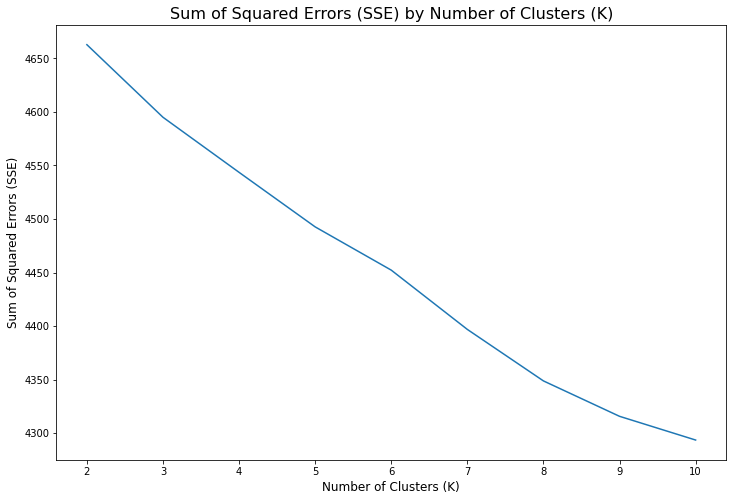

In [19]:
## SSE Validation Curve
plt.figure(figsize=(12,8))
plt.plot(k_values, sse_hard_coded)
plt.xlabel('Number of Clusters (K)',fontsize=12)
plt.ylabel('Sum of Squared Errors (SSE)',fontsize=12)
plt.title('Sum of Squared Errors (SSE) by Number of Clusters (K)',fontsize=16)


## Save to png
#plt.savefig("Tables_Graphics/sse_validation.png",facecolor='white', dpi=300)

plt.show()

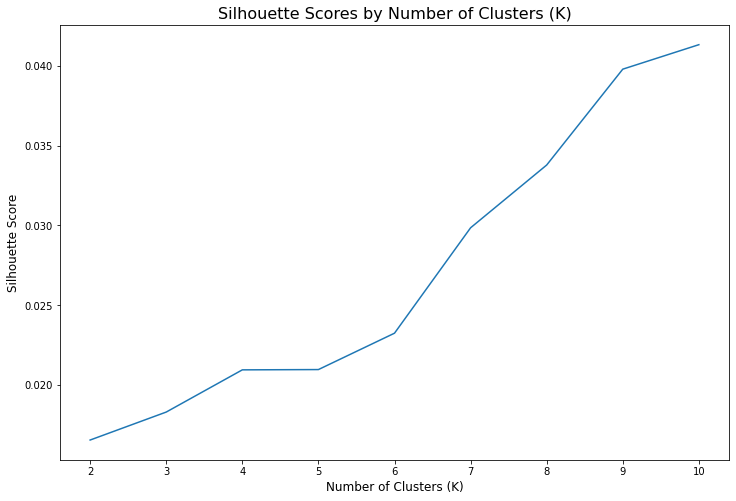

In [20]:
## Silhouette Validation Curve
plt.figure(figsize=(12,8))
plt.plot(k_values, silhouette_hard_coded)
plt.xlabel('Number of Clusters (K)',fontsize=12)
plt.ylabel('Silhouette Score',fontsize=12)
plt.title('Silhouette Scores by Number of Clusters (K)',fontsize=16)

## Save to png
#plt.savefig("Tables_Graphics/silhouette_validation.png",facecolor='white', dpi=300)

plt.show()

In [21]:
## Implementing KMeans with K = 7
k_means = KMeans(random_state = 123, n_clusters = 7)

## Making clustering predictions
k_means_labels = k_means.fit_predict(complaints_dtm)

In [22]:
## Organizing text and labels into dataframe
k_means_df = pd.DataFrame({'complaint':complaints,'cluster':k_means_labels})

## Check it out
k_means_df.head(10)

,complaint,cluster
0,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,5
1,"There is inaccurate, misleading, incorrect, ou...",5
2,To : Whom It May concern : I am writing to dis...,6
3,I recently reviewed my credit profile and noti...,3
4,I sent TransUnion a letter requesting my infor...,5
5,I attended XXXX XXXX XXXX and received fundi...,5
6,XXXX continues to report bankruptcy related in...,5
7,I am a victim od identity theft. My informatio...,1
8,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S...",5
9,These accounts arent mine. Please remove them.,4


In [23]:
## Checking out number of documents per cluster
k_means_df.groupby(by='cluster').agg('count')

,complaint
cluster,
0,89
1,1065
2,350
3,345
4,917
5,2067
6,167


In [24]:
## Combining the k-means results with the dtm df
k_means_dtm_df = pd.concat([k_means_df, complaints_dtm_df], axis=1)

## Check it out
k_means_dtm_df.head(10)

,complaint,cluster,000,01,06,09,10,100,1000,10000,...,xxxxxx,year,years,yes,yesterday,york,young,yrs,zero,zip
0,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"There is inaccurate, misleading, incorrect, ou...",5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,To : Whom It May concern : I am writing to dis...,6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I recently reviewed my credit profile and noti...,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,I sent TransUnion a letter requesting my infor...,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,I attended XXXX XXXX XXXX and received fundi...,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.078435,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,XXXX continues to report bankruptcy related in...,5,0.0,0.0,0.0,0.0,0.137428,0.0,0.0,0.0,...,0.0,0.0,0.103890,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,I am a victim od identity theft. My informatio...,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S...",5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,These accounts arent mine. Please remove them.,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
## Summing up total tf-idf weights by cluster and term
cluster_term_weights = pd.DataFrame(k_means_dtm_df.groupby(['cluster']).sum()).transpose()

## Resetting index so the term is in its own column
cluster_term_weights = cluster_term_weights.reset_index()

## Check it out
cluster_term_weights.head(10)

cluster,index,0,1,2,3,4,5,6
0,000,0.000000,0.000000,0.000000,0.000000,0.000000,2.369317,0.000000
1,01,0.073130,0.261722,0.000000,0.000000,0.000000,0.739420,0.000000
2,06,0.000000,0.530094,0.000000,0.445607,0.000000,0.145820,0.000000
3,09,0.000000,0.226626,0.373924,0.222804,0.000000,0.078536,0.000000
4,10,0.027833,3.778630,0.000000,0.000000,3.192559,6.756892,0.956342
5,100,0.000000,3.196487,0.000000,0.321691,4.267624,7.037393,0.000000
6,1000,0.000000,1.263688,0.000000,0.000000,7.936567,6.589710,2.213253
7,10000,0.000000,1.043983,0.000000,0.000000,1.595159,0.916711,2.143584
8,100000,0.000000,0.120405,0.000000,0.000000,0.000000,0.358698,0.000000
9,1001,0.357925,0.000000,0.000000,0.000000,0.000000,0.094878,0.000000


In [26]:
## Writing cluster term weights to csv
#cluster_term_weights.to_csv('Tables_Graphics/k_means_cluster_term_weights.csv')

### Section 4: Latent Dirichlet Allocation (LDA)

In [27]:
#### Creating a loop to loop through different numbers of topics and show the top words per topic

for i in range(2,5):
    lda = LatentDirichletAllocation(n_components=i, random_state=123)
    
    ## Alpha = Corpus-level document topic proportions
    alpha = lda.fit_transform(complaints_dtm)

    ## Beta = document-level topic-word proportions
    beta = lda.components_

    ## Creating objects with the feature names and the number of words per topic that I'm interested in viewing
    feature_names = tfidf_vectorizer.get_feature_names()
    number_words = 25 
    
    ## Printing headers for that set of topics
    print("\n")
    print("Results with ",i," topics:")
    print("\n")

    ## Looping through the topics and printing out the top words
    for topic_index, topic in enumerate(lda.components_):

            message = "Topic #%d: " % topic_index    ## getting the topic number

            message += " ".join([feature_names[i]
                for i in topic.argsort()[:-number_words - 1:-1]])  ## getting the list of top words for that topic

            message += "\n"   ## adding space for readability

            print(message)



Results with  2  topics:


Topic #0: accounts identity theft fraudulent victim items report remove information credit consumer opened reporting listed pulled section account unknown ftc acct act request collection belong open

Topic #1: credit account report accounts reporting information inaccurate late removed bureaus payment paid company reported loan experian file balance did payments card personal inquiries date sent



Results with  3  topics:


Topic #0: identity theft information victim consumer report section accounts credit opened reporting items acct account act listed block request fair fraudulent remove result agency charge 12

Topic #1: credit account report accounts reporting information inaccurate late removed bureaus payment experian company reported file paid did payments balance loan card inquiries debt sent personal

Topic #2: accounts remove items fraudulent credit report oh unknown pulled open belong time ftc theft identity soon ed dept opened possible student p

In [28]:
## Implementing LDA with 2 topics
lda = LatentDirichletAllocation(n_components=2, random_state=123)

In [29]:
## Alpha = Corpus-level document topic proportions
alpha = lda.fit_transform(complaints_dtm)

## Confirming shape of alpha
alpha.shape

(5000, 2)

In [30]:
## Taking a look at what alpha looks like
pd.DataFrame(alpha).head(10)

,0,1
0,0.678165,0.321835
1,0.339878,0.660122
2,0.939360,0.060640
3,0.149675,0.850325
4,0.209425,0.790575
5,0.347407,0.652593
6,0.189919,0.810081
7,0.570767,0.429233
8,0.415005,0.584995
9,0.288274,0.711726


In [31]:
## Beta = document-level topic-word proportions
beta = lda.components_
beta.shape

(2, 3394)

In [32]:
## Taking a look at what beta looks like
pd.DataFrame(beta)

,0,1,2,3,4,5,6,7,8,9,...,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393
0,0.561788,0.778221,1.268091,1.054814,4.936996,8.233929,17.175019,5.391691,0.596184,0.935927,...,0.998516,0.614328,17.685326,0.528427,0.713682,0.526692,0.515497,0.817263,0.533118,0.609136
1,2.807528,1.296051,0.853429,0.847076,10.775261,7.589267,1.828199,1.307746,0.882919,0.516876,...,2.064880,21.154277,38.263289,2.287850,4.388218,1.761955,1.114640,1.211886,3.902181,1.150403


In [33]:
## Creating objects with the feature names and the number of words per topic that I'm interested in viewing
feature_names = tfidf_vectorizer.get_feature_names()
number_words = 20 

## Looping through the topics and printing out the top words
for topic_index, topic in enumerate(lda.components_):
       
        message = "Topic #%d: " % topic_index    ## getting the topic number
        
        message += " ".join([feature_names[i]
            for i in topic.argsort()[:-number_words - 1:-1]])  ## getting the list of top words for that topic
        
        message += "\n"   ## adding space for readability
        
        print(message)

Topic #0: accounts identity theft fraudulent victim items report remove information credit consumer opened reporting listed pulled section account unknown ftc acct

Topic #1: credit account report accounts reporting information inaccurate late removed bureaus payment paid company reported loan experian file balance did payments



In [34]:
## Checking on how many documents had each topic as its primary topic
alpha_df = pd.DataFrame(alpha)
alpha_df['Max'] = alpha_df.idxmax(axis=1)
alpha_df.groupby(by='Max').agg('count')[0]

Max
0    1634
1    3366
Name: 0, dtype: int64

### Section 5: Supervised Learning with Naive Bayes Classifier

In [35]:
## Creating target array for the sub-issue
sub_issue = complaints_data['sub_issue']
sub_issue.shape

(5000,)

In [36]:
## Setting up the label encoder
label_encoder = LabelEncoder()

## Encoding the categorical target array
label_encoder.fit(sub_issue)
sub_issue = label_encoder.transform(sub_issue)

## Check it out
print(label_encoder.classes_)

['Account information incorrect' 'Account status incorrect'
 'Information belongs to someone else'
 'Information is missing that should be on the report'
 'Old information reappears or never goes away'
 'Personal information incorrect' 'Public record information inaccurate']


In [37]:
## Checking on shape of tfidf dtm
complaints_dtm_df.shape

(5000, 3394)

In [38]:
## Implementing Naive Bayes
naive_bayes = MultinomialNB()

## Getting cross-validated scores
cross_vals_nb = cross_val_score(naive_bayes, complaints_dtm_df, sub_issue, cv = 5, error_score = 'raise')
cross_vals_nb_mean = np.mean(cross_vals_nb)

## Print results
print("Average Cross-Validated Score from Naive Bayes:",round(cross_vals_nb_mean,4))

Average Cross-Validated Score from Naive Bayes: 0.7214


In [39]:
## Making predictions with Naive Bayes and 5-fold cv
sub_issue_preds_nb = cross_val_predict(naive_bayes, complaints_dtm_df, sub_issue, cv = 5)

## Combining actuals and predictions into dataframe
predictions_nb = pd.DataFrame({'sub_issue_actual':sub_issue, 'sub_issue_predicted':sub_issue_preds_nb})

## Check it out
predictions_nb.head(10)

,sub_issue_actual,sub_issue_predicted
0,2,2
1,0,2
2,2,2
3,2,2
4,5,2
5,0,0
6,6,2
7,2,2
8,2,2
9,2,2


In [40]:
## Looking at breakdown of prediction categories
predictions_nb.groupby(by='sub_issue_predicted').agg('count')

,sub_issue_actual
sub_issue_predicted,
0,142
1,672
2,4131
5,55


In [41]:
## Looking at f-score by class
f1_score(y_true = sub_issue, y_pred = sub_issue_preds_nb, average = None, zero_division = 0)

array([0.21607378, 0.56952663, 0.8495259 , 0.        , 0.        ,
       0.37121212, 0.        ])

### Section 6: Additional Exploration of Sub-Issue Field and its Relation to Clusters / Other Results

In [42]:
## Getting the counts by sub-issue for plotting purposes
sub_issue_plotting = pd.DataFrame(complaints_data[['issue','sub_issue']].groupby(by='sub_issue').agg('count'))

## Resetting index and renaming columns
sub_issue_plotting = sub_issue_plotting.reset_index()
sub_issue_plotting.columns = ['sub_issue','count']

## Arranging in order of count
sub_issue_plotting = sub_issue_plotting.sort_values('count',ascending = False)

## Adding line breaks to make it fit visually in the graph
sub_issue_plotting = sub_issue_plotting.replace('Information belongs to someone else',
                                                'Information belongs\nto someone else')
sub_issue_plotting = sub_issue_plotting.replace('Account status incorrect', 
                                                'Account status\nincorrect')
sub_issue_plotting = sub_issue_plotting.replace('Account information incorrect', 
                                                'Account information\nincorrect')
sub_issue_plotting = sub_issue_plotting.replace('Personal information incorrect', 
                                                'Personal information\nincorrect')
sub_issue_plotting = sub_issue_plotting.replace('Old information reappears or never goes away', 
                                                'Old information\nreappears or never\ngoes away')
sub_issue_plotting = sub_issue_plotting.replace('Public record information inaccurate', 
                                                'Public record\ninformation\ninaccurate')

sub_issue_plotting = sub_issue_plotting.replace('Information is missing that should be on the report', 
                                                'Information is\nmissing that should\nbe on the report')

sub_issue_plotting

,sub_issue,count
2,Information belongs\nto someone else,3146
1,Account status\nincorrect,680
0,Account information\nincorrect,617
5,Personal information\nincorrect,209
4,Old information\nreappears or never\ngoes away,151
6,Public record\ninformation\ninaccurate,116
3,Information is\nmissing that should\nbe on the...,81


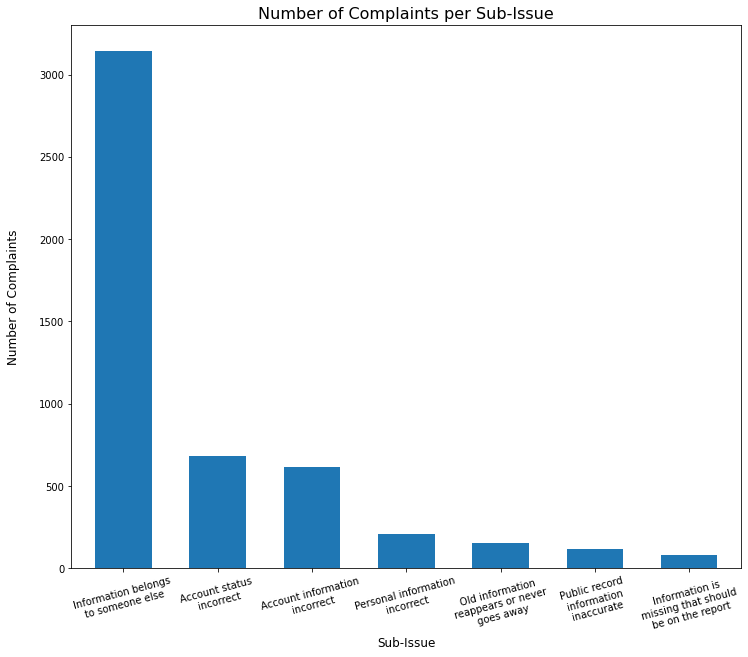

In [43]:
## Plotting the sub_issue frequency counts
sub_issue_plotting.plot(x = 'sub_issue', 
                  y = 'count', 
                  kind = 'bar',
                  figsize=(12,10),
                  legend = False,
                  width = 0.6)

plt.xlabel('Sub-Issue',fontsize=12)
plt.ylabel('Number of Complaints\n',fontsize=12)
plt.title('Number of Complaints per Sub-Issue',fontsize=16)
plt.xticks(rotation=15)

## Save to png
#plt.savefig("Tables_Graphics/sub_issues.png",facecolor='white', dpi=300)

plt.show()

In [44]:
## Making a binary version of the dtm
count_vectorizer_binary = CountVectorizer(stop_words = stop_words_adjusted, min_df = 4, binary = True)
complaints_dtm_binary = count_vectorizer_binary.fit_transform(complaints)
complaints_dtm_binary.shape

(5000, 3394)

In [45]:
## Converting the dtm object to a dataframe
complaints_dtm_binary_df = pd.DataFrame(complaints_dtm_binary.toarray())

## Mapping column names to actual words
complaints_dtm_binary_df.columns = count_vectorizer_binary.get_feature_names()

## Check it out
complaints_dtm_binary_df.head(10)

,000,01,06,09,10,100,1000,10000,100000,1001,...,xxxxxx,year,years,yes,yesterday,york,young,yrs,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
## Renaming column in k_means df for easier merge
k_means_df = k_means_df.rename(columns={"complaint": "complaint_text"})

## Creating a dataframe of just the sub-issue field for merge purposes
sub_issue_df = pd.DataFrame(complaints_data['sub_issue'])

## Combining with dtm df and k-means df
sub_issue_dtm_df = pd.concat([k_means_df, sub_issue_df, complaints_dtm_binary_df], axis=1)

## Check it out
sub_issue_dtm_df.head(10)

,complaint_text,cluster,sub_issue,000,01,06,09,10,100,1000,...,xxxxxx,year,years,yes,yesterday,york,young,yrs,zero,zip
0,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,5,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"There is inaccurate, misleading, incorrect, ou...",5,Account information incorrect,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,To : Whom It May concern : I am writing to dis...,6,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,I recently reviewed my credit profile and noti...,3,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,I sent TransUnion a letter requesting my infor...,5,Personal information incorrect,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,I attended XXXX XXXX XXXX and received fundi...,5,Account information incorrect,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,XXXX continues to report bankruptcy related in...,5,Public record information inaccurate,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,I am a victim od identity theft. My informatio...,1,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S...",5,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,These accounts arent mine. Please remove them.,4,Information belongs to someone else,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
## Narrowing to just terms that I'm interested in - identity, theft, fraud, fraudulent, victim
sub_issue_dtm_df = sub_issue_dtm_df[['complaint_text','cluster','sub_issue','identity','theft','fraud','fraudulent','victim']]

sub_issue_dtm_df.head(10)

,complaint_text,cluster,sub_issue,identity,theft,fraud,fraudulent,victim
0,ADDRESS ON THE ATTACHMENT ITR DOES NOT BELONG ...,5,Information belongs to someone else,0,0,0,0,0
1,"There is inaccurate, misleading, incorrect, ou...",5,Account information incorrect,0,0,0,0,0
2,To : Whom It May concern : I am writing to dis...,6,Information belongs to someone else,1,1,0,1,1
3,I recently reviewed my credit profile and noti...,3,Information belongs to someone else,0,0,0,1,0
4,I sent TransUnion a letter requesting my infor...,5,Personal information incorrect,1,0,0,0,0
5,I attended XXXX XXXX XXXX and received fundi...,5,Account information incorrect,0,0,0,0,0
6,XXXX continues to report bankruptcy related in...,5,Public record information inaccurate,0,0,0,0,0
7,I am a victim od identity theft. My informatio...,1,Information belongs to someone else,1,1,0,0,1
8,"TODAYS DATE : XX/XX/XXXX XXXX, XXXX XXXX SOC S...",5,Information belongs to someone else,0,0,0,0,0
9,These accounts arent mine. Please remove them.,4,Information belongs to someone else,0,0,0,0,0


In [48]:
## Pivot of how identity theft words line up with sub-issues
pd.pivot_table(sub_issue_dtm_df, index='sub_issue',
                    values=['identity','theft','fraudulent','victim'], aggfunc=np.sum)

,fraudulent,identity,theft,victim
sub_issue,,,,
Account information incorrect,17,21,15,7
Account status incorrect,13,21,13,9
Information belongs to someone else,1018,1254,967,636
Information is missing that should be on the report,2,10,3,1
Old information reappears or never goes away,6,6,7,3
Personal information incorrect,18,18,9,7
Public record information inaccurate,6,7,7,5


In [49]:
## Pivot of how k-means clusters line up with sub-issues
k_means_sub_issue_pivot = pd.pivot_table(sub_issue_dtm_df, index='cluster', columns = 'sub_issue',
                    values='complaint_text', aggfunc='count')

k_means_sub_issue_pivot

sub_issue,Account information incorrect,Account status incorrect,Information belongs to someone else,Information is missing that should be on the report,Old information reappears or never goes away,Personal information incorrect,Public record information inaccurate
cluster,,,,,,,
0,NaN,NaN,88.0,NaN,1.0,NaN,NaN
1,311.0,351.0,316.0,17.0,57.0,1.0,12.0
2,1.0,1.0,344.0,NaN,NaN,4.0,NaN
3,12.0,45.0,238.0,NaN,NaN,47.0,3.0
4,8.0,8.0,888.0,3.0,4.0,1.0,5.0
5,285.0,275.0,1106.0,61.0,89.0,156.0,95.0
6,NaN,NaN,166.0,NaN,NaN,NaN,1.0


In [50]:
## Writing to csv
#k_means_sub_issue_pivot.to_csv('Tables_Graphics/k_means_sub_issue_pivot.csv')